## Setup

In [0]:
!pip3 install tensorflow-gpu>=2.0b1 gpustat -Uq

In [0]:
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools, pickle

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.compat.v2 as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [0]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Image Classification (CIFAR10)

<img src="https://i.imgur.com/E1euTDm.png" width="400px" align="right" style="margin: 0px;padding:1em;">

In this notebook, we will be training a convolutional neural network (CNN) to perform image classification.

The CNN, [first proposed by LeCun et al. in 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) learns to extracts useful features (such as textures, shapes etc.) from images and uses them to perform tasks like image classification. Since then, CNNs like [AlexNet (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) and [ResNet (He et al., 2015)](https://arxiv.org/abs/1512.03385) have achieved breakthroughs in tasks like ImageNet, and saw widespread usage in computer vision.

We will be using the [**CIFAR10 dataset**](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in **10 classes**, with 6000 images per class. It is a commonly used research dataset. There are 50000 training images and 10000 test images. You can see examples of these images on the right side.



In [4]:
!gpustat

5aa342bf8b47         Mon Aug  5 17:02:56 2019  410.79
[0] Tesla T4         | 42'C,   0 % |     0 / 15079 MB |


## Load Dataset

Since CIFAR10 is a widely used research dataset, it is build into `tf.keras.datasets`.

In [5]:
# The data, split between train and test sets

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = np.max(y_train) + 1

# Convert class vectors to one-hot encoded vectors

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


As a best practice, we should normalize the data (scale it from `0~255` to `0.0~1.0`).

In [0]:
def normalize(ndarray):
    ndarray = ndarray.astype("float32")
    ndarray = ndarray/255.0
    return ndarray

x_train = normalize(x_train)
x_test = normalize(x_test)

## Create Model

In [7]:
# model parameters
act = "relu"
pad = "same"
ini = "he_uniform"

model = tf.keras.models.Sequential([
    Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini,
            input_shape=(32,32,3)),
    Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
    Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
    Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
    MaxPooling2D(pool_size=(4,4)),
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(rate=0.4),
    Dense(num_classes, activation="softmax")
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.5, decay=0.001)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

W0805 17:03:02.970794 140539287869312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0

## Train Model

In [9]:
train_log = model.fit(x_train, y_train,
                      validation_split=0.1,
                      batch_size=256,
                      epochs=30)

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 34s 748us/sample - loss: 1.7149 - acc: 0.3971 - val_loss: 1.5367 - val_acc: 0.4608
Epoch 2/30
45000/45000 [==============================] - 24s 541us/sample - loss: 1.2976 - acc: 0.5372 - val_loss: 1.2590 - val_acc: 0.5686
Epoch 3/30
45000/45000 [==============================] - 25s 547us/sample - loss: 1.1231 - acc: 0.5999 - val_loss: 1.0646 - val_acc: 0.6170
Epoch 4/30
45000/45000 [==============================] - 25s 551us/sample - loss: 0.9916 - acc: 0.6486 - val_loss: 0.9551 - val_acc: 0.6636
Epoch 5/30
45000/45000 [==============================] - 25s 554us/sample - loss: 0.8844 - acc: 0.6864 - val_loss: 0.9902 - val_acc: 0.6534
Epoch 6/30
45000/45000 [==============================] - 25s 557us/sample - loss: 0.7977 - acc: 0.7182 - val_loss: 0.8546 - val_acc: 0.7026
Epoch 7/30
45000/45000 [==============================] - 25s 560us/sample - loss: 0.7254 - acc: 0.7443 -

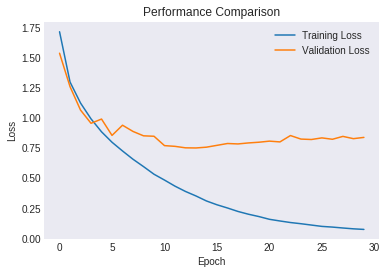

In [10]:
plt.plot(train_log.history["loss"], label="Training Loss")
plt.plot(train_log.history["val_loss"], label="Validation Loss")
plt.title("Performance Comparison")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

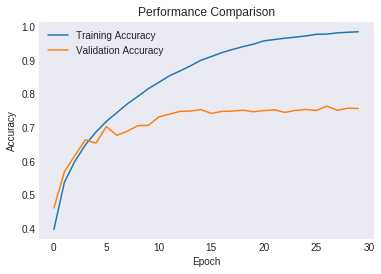

In [11]:
plt.plot(train_log.history["acc"], label="Training Accuracy")
plt.plot(train_log.history["val_acc"], label="Validation Accuracy")
plt.title("Performance Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Evaluate Model

We can evaluate the model using a simple `model.evaluate()`.

In [12]:
score = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 297us/sample - loss: 0.8840 - acc: 0.7451


If we want to gain a deeper insight into how well our model is performing, we can use Scikit-Learn's `classification_report`, as well as plot a **confusion matrix**.

* [`classification_report` Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* [`confusion_report` Document](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [13]:
classes = ["airplane", "automobile", "bird",
           "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.75      0.81      0.78      1000
  automobile       0.86      0.85      0.86      1000
        bird       0.64      0.62      0.63      1000
         cat       0.56      0.56      0.56      1000
        deer       0.71      0.69      0.70      1000
         dog       0.65      0.66      0.65      1000
        frog       0.77      0.83      0.80      1000
       horse       0.79      0.79      0.79      1000
        ship       0.88      0.81      0.84      1000
       truck       0.85      0.82      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



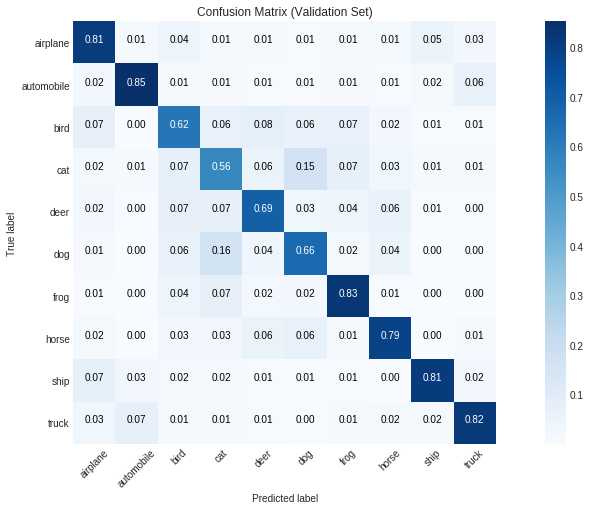

In [14]:
plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

# see the "Setup" section all the way above for
# the code for the `plot_confusion_matrix` function

plot_confusion_matrix(cnf_matrix, labels=classes)